# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tqdm import tqdm
from collections import Counter

In [2]:
df=pd.read_csv('Questions.csv',encoding='ISO-8859-1') #reading the csv file from the location 

In [3]:
df.head() 

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [4]:
tags=pd.read_csv('Tags.csv')

In [5]:
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [6]:
tags['Tag']=tags['Tag'].astype(str) #typecasting of 'Tags' initial datatype to string
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags)) # Grouping Tags by Id and joining them 

In [7]:
grouped_tags.reset_index() # index has been flawed while grouping therefore resetting index
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})
grouped_tags_final.head()

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [8]:
df = df.merge(grouped_tags_final, on='Id') #merging grouped Tags to main dataframe 

In [9]:
df.head(15)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tags
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction
5,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,c++ oop class nested-class
6,470,71.0,2008-08-02T15:11:47Z,2016-03-26T05:23:29Z,13,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,.net web-services
7,580,91.0,2008-08-02T23:30:59Z,NaN,21,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...,sql-server sql-server-2005 deployment release-...
8,650,143.0,2008-08-03T11:12:52Z,NaN,79,Automatically update version number,<p>I would like the version property of my app...,c# visual-studio versioning
9,810,233.0,2008-08-03T20:35:01Z,NaN,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,windows visual-studio registry installation


code written below is for cleaning the body of various HTML Tags 

In [10]:
import re
nlp = spacy.load('en_core_web_lg')
def normalize_text(text):
    tm1 = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
    tm2 = re.sub('<code>.*?</code>', '', tm1, flags=re.DOTALL)
    tm3 = re.sub('<[^>]+>', '', tm1, flags=re.DOTALL)
    return tm3.replace("\n", "")

In [11]:
df['Body_Cleaned_1'] = df['Body'].apply(normalize_text) # Apply filteration on to body 

In [12]:
df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tags,Body_Cleaned_1
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air,I've written a database generation script in S...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging,Are there any really good tutorials explaining...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap,Has anyone got experience creating SQL-based A...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space,This is something I've pseudo-solved many time...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction,I have a little game written in C#. It uses a ...


In [13]:
df.Title.value_counts() # get the count of questions that are identicle 

Uncaught TypeError: undefined is not a function                             6
Input string was not in a correct format                                    6
Object reference not set to an instance of an object                        4
Validation of viewstate MAC failed                                          3
Conversion failed when converting date and/or time from character string    3
                                                                           ..
Bubble Sort in linked lists C                                               1
jquery checked checkbox on refresh and unique value query                   1
Auto-incrementing from 0 in Rails migrations                                1
mysql database suddenly occupies all the space in server                    1
Shopify: Global variable data type                                          1
Name: Title, Length: 1263995, dtype: int64

In [14]:
df.Title=df.Title.drop_duplicates(keep='first') #get rid of the identical queries 
df.Title.value_counts()

Make return from S3 indexing function "[" invisible                              1
Excel - Delete Rows From Sheet 1 Based on Values From Sheet 2                    1
Why does my code open two Microsoft Office Word instances?                       1
React router throws and error when getting async component                       1
Logcat viewer in Eclipse flickers annoyingly                                     1
                                                                                ..
DeviceStatus.ApplicationMemoryUsageLimit doesn't work on WP Silverlight 8.1      1
permission to start Docker                                                       1
NamedPipeClientStream can not access to NamedPipeServerStream under session 0    1
Concatenate columns from different files and compare between files               1
Shopify: Global variable data type                                               1
Name: Title, Length: 1263995, dtype: int64

In [15]:
df.drop(columns=['OwnerUserId','CreationDate','ClosedDate','Body'],inplace=True) #remove the data that we don't require for trainig the model
df.rename(columns={'Body_Cleaned_1':'Body'},inplace=True) #cleaned body_1 is renamed to Body (to avoid confusions)

In [16]:
df.head()

,Id,Score,Title,Body,Tags,Body_Cleaned_1
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air,I've written a database generation script in S...
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging,Are there any really good tutorials explaining...
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap,Has anyone got experience creating SQL-based A...
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space,This is something I've pseudo-solved many time...
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction,I have a little game written in C#. It uses a ...


In [17]:
df['Tags']=df['Tags'].apply(lambda x: x.split()) # splitting on the basis of " " so we get each tag as by refrencing [0]..[n]
all_tags=[item for sublist in df['Tags'].values for item in sublist] # get all tags 
unique_tags = list(set(all_tags)) # get unique tags 
len(unique_tags)

37035

37035 woah! that's a lot of Tags . For my purpose i am training with 100 most common Tags 

In [18]:
counter = Counter(all_tags)#we imported a module called Counter
most_occur = counter.most_common(100)#100 most occured tags 
tags = [i[0] for i in most_occur]
count = [i[1] for i in most_occur]
tags[:5],count[:5]

(['javascript', 'java', 'c#', 'php', 'android'],
 [124155, 115212, 101186, 98808, 90659])

Let us plot count frequency graph of Tags

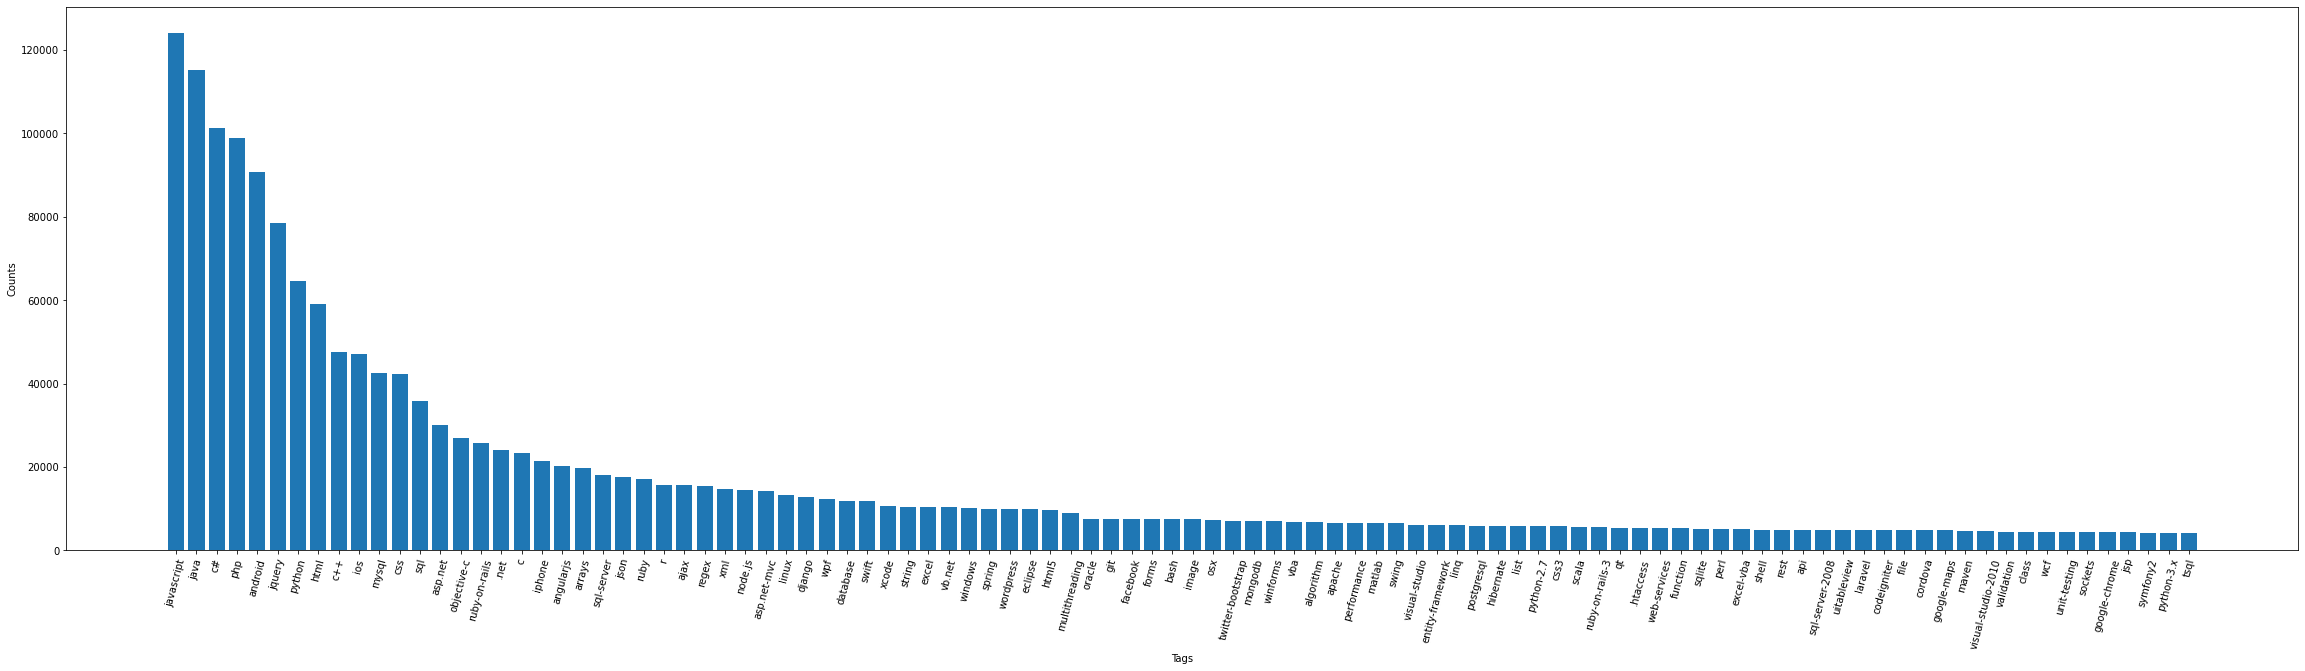

In [19]:
from matplotlib import pyplot as plt
x = np.arange(len(most_occur))
fig, ax = plt.subplots(figsize=(40, 10))
plt.bar(x, height= count) 
plt.xticks(x, tags, rotation=75)
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

Word Cloud is an interesting visual plot. Here the size of the word represents how often it is found. A look at the word cloud shows that “c#”, “java”, “php”, “asp.net”, “javascript”, “c++” are some of the most frequent tags.

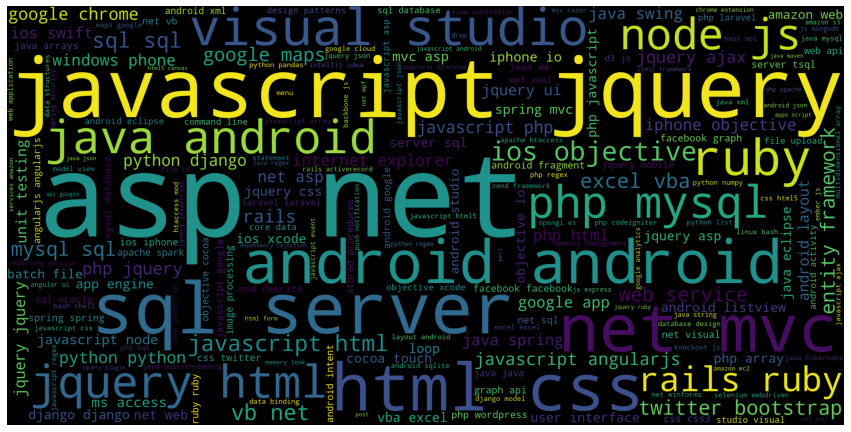

In [20]:
from wordcloud import WordCloud
def generate_wordcloud(text):
    wordcloud = WordCloud(width=3000,height = 1500).generate(text)
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

generate_wordcloud(" ".join(all_tags))

In [21]:
df.shape

(1264216, 6)

Since we have many rows of data , we will apply some operations to trim down the not-so-useful amount of data . We already selected most common 100 tags using counter . and below is the code that performs operation to filter out the tags that are not in our common tags bucket.

In [22]:
def most_common(x):
    tags_filtered = []
    for i in range(0, len(x)):
        if x[i] in tags:
            tags_filtered.append(x[i])
    return tags_filtered

In [23]:
df['Tags'] = df['Tags'].apply(lambda x: most_common(x)) 
df['Tags'] = df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [24]:
df.dropna(subset=['Tags'], inplace=True)
df.shape

(1057478, 6)

In [27]:
print(1264216-1057478,"enteries were dropped")

206738 enteries were dropped


In [33]:
import nltk 
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\arish\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\arish\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\gazetteers.zip.
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\arish\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\genesis.zip.
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\arish\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\gutenberg.zip.
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\arish\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     C:\Users\arish\AppData\Roaming\nl

True

Now we are going to perform cleaning of our data so that it can be fed to a model. 
we are going to remove stopword,punctuations. Also we are going to lematize the body and title. 

In [34]:
token=ToktokTokenizer()
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

def clean_text(text):
  text = text.lower()
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"\'s", " ", text)
  text = re.sub(r"\'ve", " have ", text)
  text = re.sub(r"can't", "can not ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r"\'scuse", " excuse ", text)
  text = re.sub(r"\'\n", " ", text)
  text = re.sub(r"\'\xa0", " ", text)
  text = re.sub('\s+', ' ', text)
  text = text.strip(' ')
  return text

def strip_list_noempty(mylist):
  newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
  return [item for item in newlist if item != '']

def clean_punct(text): 
  words=token.tokenize(text)
  punctuation_filtered = []
  regex = re.compile('[%s]' % re.escape(punct))
  remove_punctuation = str.maketrans(' ', ' ', punct)
  for w in words:
      if w in tags:
          punctuation_filtered.append(w)
      else:
          punctuation_filtered.append(regex.sub('', w))

  filtered_list = strip_list_noempty(punctuation_filtered)

  return ' '.join(map(str, filtered_list))

lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [35]:
def combine(new_df):
  new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x))
  print(1)
  new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x))
  print(2)
  new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
  print(3)
  new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x))
  print(4)
  new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
  print(5)
  new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
  print(6)
  new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x)) 
  print(7)
  new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
  print(8)
  new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x))
  return new_df

In [39]:
df=combine(df)#this might take sometime   

1
2
3
4
5
6
7
8


In [41]:
df.head()

,Id,Score,Title,Tags,Body
2,120,21,asp.net site map,"[sql, asp.net]",anyone get experience create sql-based asp.net...
3,180,53,function create color wheel,[algorithm],something pseudo-solved many time never quite ...
4,260,49,add script functionality .net applications,"[c#, .net]",little game write c use database back-end trad...
5,330,29,use nest class case,"[c++, class]",work collection class use video playback recor...
6,470,13,homegrown consumption web service,"[.net, web-services]",write web service .net app ready consume see n...


Selecting questions for training which have more than atleast 5 upvotes

In [45]:
df=df[(df['Score']>5)] 
df.shape
df.drop(columns=['Id','Score'],inplace=True)

(61846, 5)

In [53]:
df.head()

,Title,Tags,Body
0,asp.net site map,"[sql, asp.net]",anyone get experience create sql-based asp.net...
1,function create color wheel,[algorithm],something pseudo-solved many time never quite ...
2,add script functionality .net applications,"[c#, .net]",little game write c use database back-end trad...
3,use nest class case,"[c++, class]",work collection class use video playback recor...
4,homegrown consumption web service,"[.net, web-services]",write web service .net app ready consume see n...


In [66]:
#joining title and body  
y = df['Tags']
df = df.values
X = []

for i in tqdm(df):
  X.append(i[0]+' '+i[2])

100%|████████████████████████████████████████████████████████████████████████| 61846/61846 [00:00<00:00, 430635.30it/s]


In [70]:
len(X),y.shape

(61846, (61846,))

In [71]:
#since Tags column contains multi-labels we use Multi-LabelBinarizer to create a vector based output of categories 
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()
Y = multilabel_binarizer.fit_transform(y)

In [73]:
len(X),Y.shape # as we selected top 100 tags the dimensionality of labels becomes (no of examples,unique Tags)

(61846, (61846, 100))

In [74]:
Y[1]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Tfidf is a vectorizer which categorizes such that it provied different wieghts to diffferent words in the whole document .
Below is the way to import it and execute it . It follows the below given formula to compute wiegtage of different words 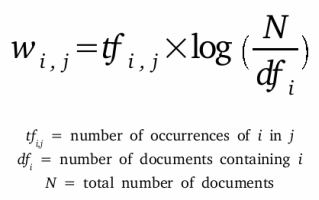

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
tfvectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
X_train = tfvectorizer.fit_transform(X)

In [79]:
X_train[1]

<1x93506 sparse matrix of type '<class 'numpy.float64'>'
	with 29 stored elements in Compressed Sparse Row format>

In [80]:
#splitting our dataset into training and testing set 
x_train_multilabel=X_train[0:45000]
x_test_multilabel=X_train[45001:]
y_train_multilabel=Y[0:45000]
y_test_multilabel=Y[45001:]

I have used OneVsRestClassifier as a model to train my data. Which folows the following algorithm for training the data . 
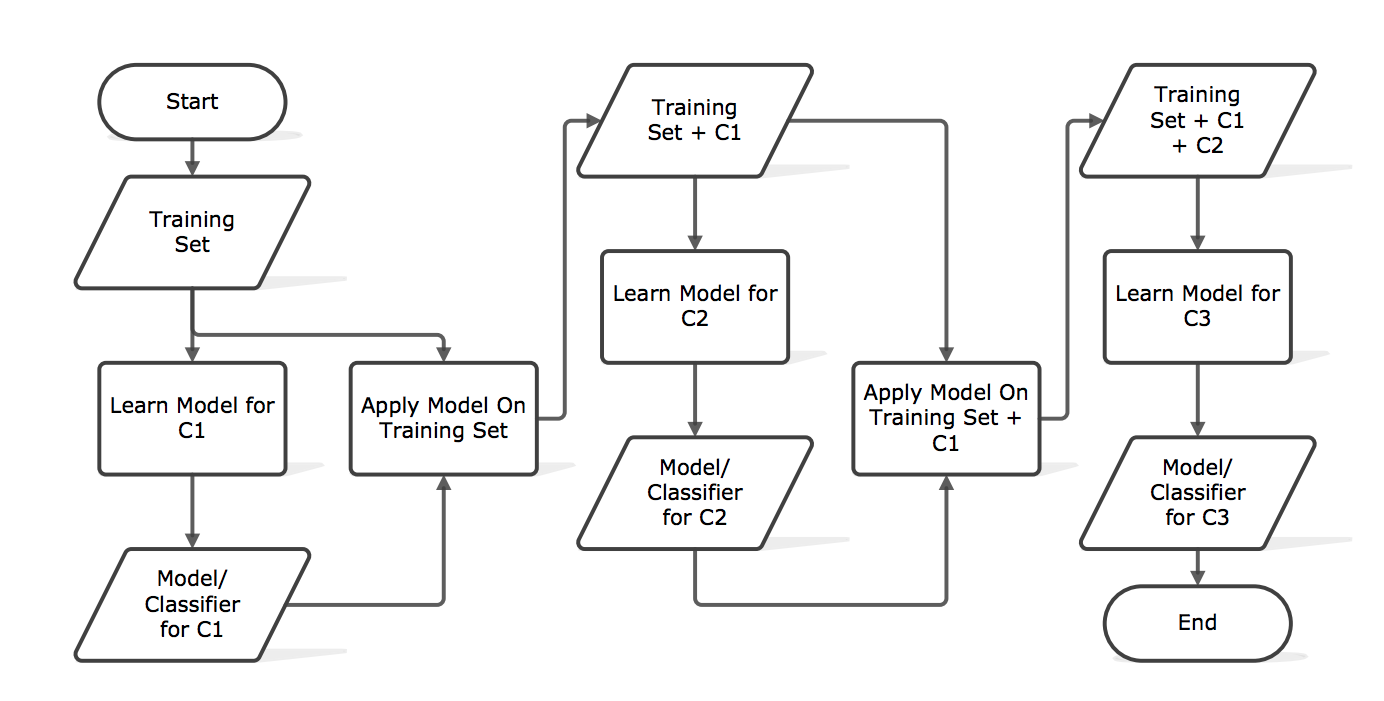

For a standard Binary of Multi-class classification problems, we can use performance metrics like Precision,Recall,F1-Score,Log-loss,AUC Curve etc..But for the present Multi-Label problem the mentioned metrics may not work well. As part of the business requirement we want high precision and recall rates for each and every predicted tag. We can use F1 Score here as it only gives good value if both the Precision and Recall are high. The F1 Score performs really well for Binary classifications. So for Multi Label Setting we can modify it into two types.
1.Micro Averaged F1 Score
2.Macro Averaged F1 Score
3.Hamming Loss
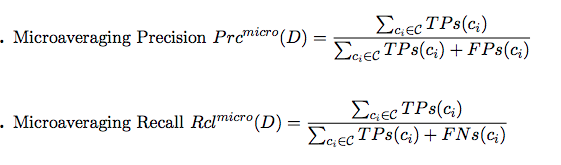

To read more about what these are please head over to 
https://medium.com/@klintcho/explaining-precision-and-recall-c770eb9c69e9

In the below given code let us understand some of the few things 
We have used loss function of 'Log' and learning rate as 0.00001 
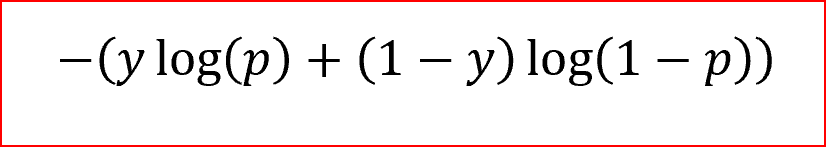
n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.
Penalized logistic regression imposes a penalty to the logistic model for having too many variables. This results in shrinking the coefficients of the less contributive variables toward zero. This is also known as regularization. ... ridge regression: variables with minor contribution have their coefficients close to zero

In [81]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train_multilabel)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test_multilabel,predictions))
print("macro f1 score :",metrics.f1_score(y_test_multilabel, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test_multilabel, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test_multilabel,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test_multilabel, predictions))

accuracy : 0.33084001187295936
macro f1 score : 0.4778380299966038
micro f1 scoore : 0.5767412389725594
hamming loss : 0.010310477886613238
Precision recall report :
               precision    recall  f1-score   support

           0       0.85      0.52      0.65        21
           1       0.47      0.15      0.23       363
           2       0.76      0.40      0.52       106
           3       0.81      0.52      0.64       197
           4       0.95      0.77      0.85      1912
           5       0.97      0.47      0.63       722
           6       0.81      0.37      0.51        60
           7       0.29      0.10      0.15        60
           8       0.63      0.24      0.35       241
           9       0.60      0.28      0.38       240
          10       0.75      0.36      0.49       233
          11       0.90      0.47      0.62       121
          12       0.74      0.45      0.56       461
          13       0.85      0.41      0.56      1398
          14       0.9

C:\Users\arish\anaconda3\envs\gputest\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\arish\anaconda3\envs\gputest\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
#saving our model 
import dill
model = 'model.sav'
tfidf='tfidf.sav'
dill.dump(classifier, open(model, 'wb'))
dill.dump(tfvectorizer, open(tfidf, 'wb'))